----------------------------------

# PART III

- **Low variance removal**
- **ML regression**

![alt](https://i.pinimg.com/originals/8c/5c/59/8c5c5923c547867c1615402754d9eb27.gif)
-----------------------------------

*This jupyter is the explanation. The *real thing* is available in the **Cloud Function** folder. 


----------------------------------

Let's have fun :D

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn import preprocessing
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

In [2]:
df=pd.read_csv("input/dataset_final_processed.csv",index_col=[0])

In [3]:
df.drop(columns=["outliers_score"],inplace=True)

### Removing not strongly correlated features
(switched by Recursive Feature Elimination)

### First attributes selection: Erasing low variance elements

Let's remove the attibutes (columns) which values are quite constant in the whole dataset, so they're not offering much information when everything else is changing.

In [4]:
def variance_threshold_selector(data, threshold):
    '''
    It removes any attribute (column) than vary less than the percentaje of the threshold
    '''
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [5]:
low_v = df.drop(columns=["date","unemployment" ])

In [6]:
X_raw= variance_threshold_selector(low_v, 20) # removing values than vary less than 5%
print("attributes before", low_v.shape,"attributes now", X_raw.shape)

attributes before (82, 118) attributes now (82, 103)


In [7]:
print("removed features: ","\n")
removed=[]
for c in low_v.columns:
    if c not in X_raw.columns:
        #print(c)
        removed.append(c)
removed=pd.DataFrame(removed, columns =["Removed_columns"])

removed.to_csv("./input/removed_features.csv")   #<==========================

removed

removed features:  



,Removed_columns
0,precio_petroleo_1
1,inflacion_economica
2,banco_mundial
3,precio_petroleo_2
4,prosperidad_economica_y_finanzas
5,precio_vivienda
6,subsidios
7,censura_en_medios
8,racismo
9,desescalada


### Normalization / Standarization

Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

In other hand, Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data

In [8]:
# Normalizacion with sklearn
# remove dates and target
#X_raw = df.drop(columns=["date","unemployment","outliers_score" ]) #already removed in low_v

normalizer = preprocessing.MinMaxScaler()
X = pd.DataFrame(normalizer.fit_transform(X_raw))

#standardizer = preprocessing.StandardScaler()
#X = pd.DataFrame(standardizer.fit_transform(X_raw))

X.columns= X_raw.columns
X.shape
target=df["unemployment"]
print("X shape: ", X.shape, ", target shape: ", target.shape)
X.head(2)

X shape:  (82, 103) , target shape:  (82,)


,ejercito,inestabilidad_politica,vigilancia,juicio,terrorismo,protestas,seguridad_nacional,corrupcion_1,rebelion,refugiados_1,...,steam,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,vox,yoga,zoom
0,0.772059,0.894425,0.640186,0.780539,0.438318,0.99576,0.420146,0.705565,0.579915,0.780032,...,0.632353,0.43,0.01,0.57,0.27,0.12,0.052632,0.34,0.870370,0.185185
1,0.727457,0.684682,0.433535,0.456219,0.000000,0.00000,0.793754,0.648262,0.490130,0.836825,...,0.529412,1.00,0.00,0.44,1.00,0.14,0.078947,0.15,0.851852,0.111111


# RFE

In [9]:
# all but last 4 rows
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# last 4 rows, which are the ones I have no data and I want to infer
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

In [10]:
print(X_train.shape, target_train.shape)

(78, 103) (78,)


# cross val predict with uncertainties

In [11]:
import sklearn.metrics as metrics 
from sklearn.metrics import make_scorer
from math import sqrt
import collections


regression={"Linear":   LinearRegression(),
            "Lasso":    Lasso(alpha=0.1, selection="random", max_iter=10000, random_state=42),
            "Rigde":    Ridge(alpha=0.1,max_iter=10000, solver='auto', random_state=42)
            }

metrics_dict= {
    #"r2": metrics.r2_score, # already checked
    "mae": make_scorer(metrics.mean_absolute_error),
    "rmse": make_scorer(lambda y,y_pred: sqrt(metrics.mean_squared_error(y,y_pred))),
    "mape": make_scorer(lambda y,y_pred: np.mean(np.abs(y-y_pred)/y)*100),
    "mean_squared_error": make_scorer(metrics.mean_squared_error),
    "explained_variance": make_scorer(metrics.explained_variance_score),
    "max_error": make_scorer(metrics.max_error),
    "median_absolute_error": make_scorer(metrics.median_absolute_error)
}


min_number_features =  df.shape[0]//8 # Min number of features to play with

model_performance={}
results={}
for r in regression:
    rfecv = RFECV(estimator=regression[r],
                step=1, 
                  min_features_to_select=min_number_features, 
                  cv=KFold(n_splits=10,
                        shuffle=True,
                        random_state=42),
                  scoring='r2')
    rfecv.fit(X_train, target_train)
    score = rfecv.score(X_train, target_train)

    if score <=0.99:
        model_performance[score]=[r,regression[r]]
        
        
model_performance = collections.OrderedDict(sorted(model_performance.items(), reverse=True))
score=list(model_performance.keys())[0]
model_name=list(model_performance.values())[0][0]
model_config=list(model_performance.values())[0][1]

print(score, model_name, model_config)
#print(model_performance)

0.7882911360390148 Lasso Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='random', tol=0.0001, warm_start=False)


In [12]:
# esto lo vamos a usar posteriormente para rellenar el df de resultados
results["model"]=model_name
results["r2"]=round(score,3)
results

{'model': 'Lasso', 'r2': 0.788}

In [13]:
# Ranking of how important are the following keywords to infer in Google searches in Spain
# the keyword "unemployment"
ranking_features=pd.DataFrame()
ranking_features["features"]=X_train.columns
ranking_features["top_important"]=rfecv.ranking_
ranking_features.sort_values(by="top_important", ascending=True, inplace=True, ignore_index=True)
ranking_features.to_csv("input/ranking_of_features.csv")  # <========================
ranking_features.head()

,features,top_important
0,energias_renovables,1
1,coronavirus,1
2,en casa,1
3,banco alimentos,1
4,videoconferencia,1


In [14]:
# now I have the chosen features, let's use cross validation with the chosen columns:
chosen_features=list(ranking_features[ranking_features["top_important"]<=10]["features"])
X_train= X[chosen_features].iloc[:-4]
X_test=X[chosen_features].iloc[-4:]
len(X_train.columns)

19

In [15]:
# Validación y evaluación del modelo.
evaluation = cross_validate(model_config, X_train, target_train,
                cv = KFold(n_splits=10), scoring = metrics_dict)

In [44]:
# remove infs
for e in evaluation:
    if np.inf in evaluation[e]:
        control_infs== list(evaluation[e])
        control_infs= [e for e in control_infs if e != np.inf]
        evaluation[e]=np.asarray(control_infs)

In [45]:
results["mae"]=round(evaluation["test_mae"].mean(),3)
results["mae_error"]=round(evaluation["test_mae"].std(),3)

results["rmse"]=round(evaluation["test_rmse"].mean(),3)
results["rmse_error"]=round(evaluation["test_rmse"].std(),3)


results["mape"]=round(evaluation["test_mape"].mean(),3)
results["mape_error"]=round(evaluation["test_mape"].std(),3)


results["mse"]=round(evaluation["test_mean_squared_error"].mean(),3)
results["mse_error"]=round(evaluation["test_mean_squared_error"].std(),3)


results["explained_var"]=round(evaluation["test_explained_variance"].mean(),3)
results["explained_var_error"]=round(evaluation["test_explained_variance"].std(),3)

results["median_abs_error"]=round(evaluation["test_median_absolute_error"].mean(),3)
results["median_abs_error_eror"]=round(evaluation["test_median_absolute_error"].std(),3)

results_df=pd.DataFrame.from_dict(results,orient='index').T

In [46]:
results_df

,model,r2,mae,mae_error,rmse,rmse_error,mape,mape_error,mse,mse_error,explained_var,explained_var_error,median_abs_error,median_abs_error_eror
0,Lasso,0.788,8.1,7.823,10.566,11.338,28.437,13.324,240.187,546.247,-1.59,2.111,5.689,3.556


In [43]:
for m in metrics_dict:
        
    y_pred = cross_val_predict(model_config, 
                               X_train, target_train,
                               cv = KFold(n_splits=5, shuffle=True, random_state=42),
                               n_jobs=-1)  
            # To perform the leave-one-out I could have done also:
            #cv= LeaveOneOut()
        
            # metrics
    score = metrics_dict[m](target_train, y_pred)

0.0

,features,top_important
0,energias_renovables,1
1,coronavirus,1
2,en casa,1
3,banco alimentos,1
4,tinder,1
...,...,...
98,bildu,91
99,estado de alarma,92
100,podemos,93
101,nacionalismo,94


In [ ]:
asdfasdfadsf

0.9678778819242775 Rigde Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, random_state=42, solver='auto', tol=0.001)


In [15]:
# Ranking of how important are the following keywords to infer in Google searches in Spain
# the keyword "unemployment"
ranking_features=pd.DataFrame()
ranking_features["features"]=X_train.columns
ranking_features["top_important"]=rfecv.ranking_
ranking_features.sort_values(by="top_important", ascending=True, inplace=True, ignore_index=True)
ranking_features.to_csv("input/ranking_of_features.csv")  # <========================
ranking_features

,features,top_important
0,ejercito,1
1,inmigracion_2,1
2,infeccion,1
3,independentismo,1
4,hbo,1
...,...,...
98,bildu,27
99,estado de alarma,28
100,podemos,29
101,nacionalismo,30


# Plotting results

In [16]:
inferred_results=list(rfecv.predict(X)) # this is just to avoid generating nans in df
unemployment=list(df.unemployment)
date=df.date
#print(len(inferred_results),len(unemployment),len(date))

result=pd.DataFrame()
result["date"]=df["date"]
result["real_searches"]=unemployment
result["inferred_results"]=inferred_results

result["inferred_results"]=result["inferred_results"].apply(lambda x: 0 if x<0 else round(x,2))
result.tail(10)

,date,real_searches,inferred_results
97,2020-11-15,32.0,32.23
98,2020-11-22,26.0,29.26
99,2020-11-29,33.0,28.01
100,2020-12-06,24.0,21.17
101,2020-12-13,27.0,25.83
102,2020-12-20,0.0,7.94
103,2020-12-27,0.0,35.76
104,2021-01-03,0.0,32.06
105,2021-01-10,0.0,43.56
106,2021-01-17,0.0,0.00


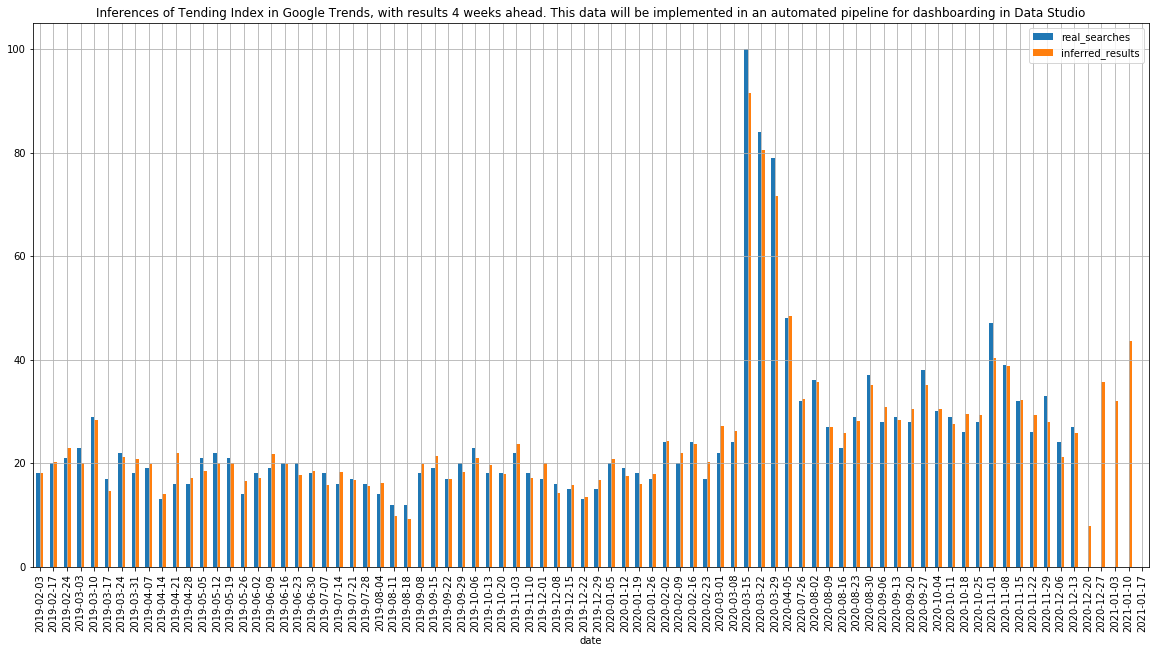

In [17]:
# visualization
result.plot(x="date",
            y=["real_searches","inferred_results"],
            figsize=(20,10), 
            kind="bar",
            title="Inferences of Tending Index in Google Trends, with results 4 weeks ahead. This data will be implemented in an automated pipeline for dashboarding in Data Studio",
            grid=True)

# cross_val_score with standard deviation

In [18]:

today=datetime.now().date()
# this is done with the RFECV results and appended in the final csv
min_number_features =  df.shape[0]//10
mean = result.real_searches.head(-4).mean()
N = len(result.real_searches.head(-4))
y_real=result.real_searches.head(-4) 
y_pred=result.inferred_results.head(-4)
mape=round(np.abs( ((y_real-y_pred)/y_real).sum() /N )*100,3)

metrics={"date":[today], 
         "selected_columns":[rfecv.n_features_],
         "model":model_name,
        "mape":[mape],
         "alg_rmse":[round(score,3)]}

# Here starts cross_val_score
metrics_cross_val_score=[
                        "neg_root_mean_squared_error",
                        "neg_mean_squared_error",
                         "r2",
                         "explained_variance",
                         "neg_mean_absolute_error",
                         "max_error",
                         "neg_median_absolute_error"
                        ]

regression=model_config # the winner model before
#X_train= X_train[ranking_features[ranking_features["top_important"]==1]["features"]] #selecting the same columns than before
X_train = X_train[list(X_train.columns)[:rfecv.n_features_]] # taking all the selected features before

# No X_train means working with all columns
for m in metrics_cross_val_score:
    score=cross_val_score(regression, 
        X_train,
        target_train, 
        cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring=m)

    score= [-score.mean()/mean,score.std()/mean]    

    metrics[m]=round(score[0],2)
    dev="std_"+m
    metrics[dev]=round(score[1],2)

weekly_score=pd.DataFrame(metrics)
weekly_score.rename(columns={
                   'neg_root_mean_squared_error': "rmse", 
                   'std_neg_root_mean_squared_error': "error_rmse",
                   'neg_mean_squared_error':"mse", 
                   'std_neg_mean_squared_error':"error_mse", 
                   'std_r2':"error_r2",
                   'std_explained_variance':"error_explained_variance",
                    'neg_mean_absolute_error':"mae", 
                   'std_neg_mean_absolute_error':"error_mae", 
                   'std_max_error':"error_max_error", 
                   'neg_median_absolute_error':"median_ae",
                   'std_neg_median_absolute_error':"error_median_ae"}, inplace=True)

In [19]:
weekly_score
# why this metrics are so bad compared with the RFECV process puzzles me. Pending task

,date,selected_columns,model,mape,alg_rmse,rmse,error_rmse,mse,error_mse,r2,error_r2,explained_variance,error_explained_variance,mae,error_mae,max_error,error_max_error,median_ae,error_median_ae
0,2021-01-24,73,Rigde,inf,0.968,0.54,0.23,8.45,6.6,0.09,0.12,0.07,0.11,0.39,0.17,1.16,0.52,0.29,0.14


# RFECV selection of columns

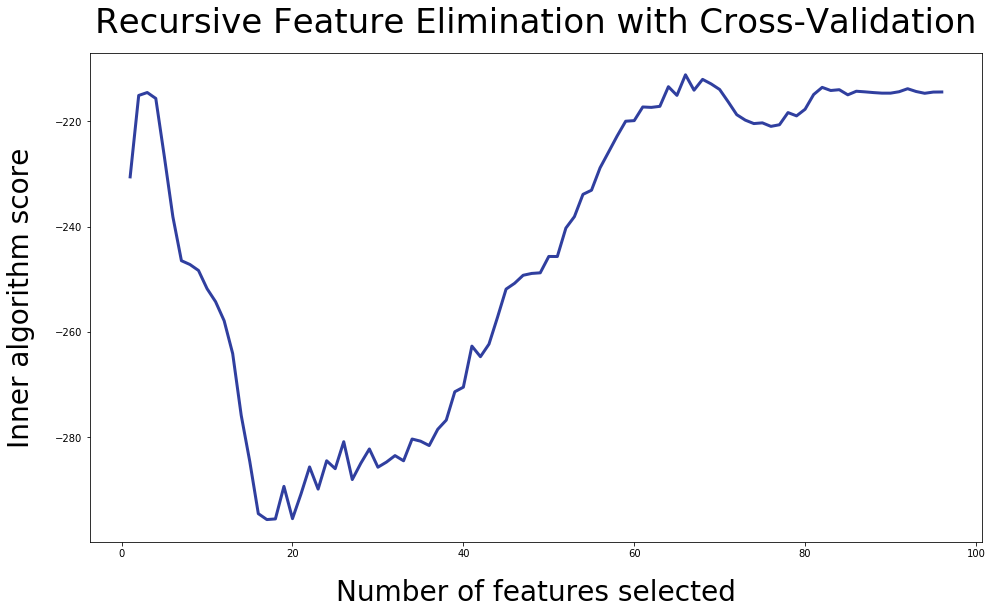

In [20]:
from matplotlib import pyplot
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=34, pad=20)
plt.xlabel('Number of features selected', fontsize=28, labelpad=20)
plt.ylabel('Inner algorithm score', fontsize=28, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.savefig("./input/RFE_columns.jpg")   # <====================

plt.show()

In [21]:
# Inferences 4 weeks ahead
rfecv.predict(X_test)

array([ 35.75962998,  32.06467441,  43.56322208, -11.67526315])